In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from math import log
import string

In [13]:
def update_database(database, title, text, headings):
    temp = ''
    temp += title
    for line in text:
        temp += (' '+line)
    for heading in headings:
        temp += (' '+heading)
    database.loc[len(database.index)] = [title, text, headings, temp]
    return database

def get_subheadings(headingid, database, listofrelatedids=None, nextheading=False):
    if listofrelatedids is None:
        listofrelatedids = []
    if not nextheading:
        if len(database.iloc[headingid]['subheadings'])!=0:
            subheadingid = database.iloc[headingid]['subheadings'][0]
            listofrelatedids.append(subheadingid)
            listofrelatedids = get_subheadings(subheadingid, database, listofrelatedids, True)
    elif nextheading:
        if len(database.iloc[headingid]['nextheading'])!=0:
            nextheadingid = database.iloc[headingid]['nextheading'][0]
            listofrelatedids.append(nextheadingid)
            listofrelatedids = get_subheadings(nextheadingid, database, listofrelatedids, True)
    return listofrelatedids

In [14]:
headings.head()

,headingnumber,heading,subheadings,paragraphs,nextheading,preprocessed_heading
0,2.0,Table of Contents,[1],[],[540],[]
1,9.0,Preface,[],[],[2],[preface]
2,9.0,Chapter 1: Blockchain 101,[3],[],[22],[blockchain]
3,21.0,The growth of blockchain technology,[],[],[4],"[growth, blockchain, technology]"
4,21.0,Progress toward maturity,[],[],[5],"[progress, toward, maturity]"


In [16]:
oldheadings = pd.read_pickle('database.pickle')
text = pd.read_pickle('text.pickle')

### Data Structure of each topic in the database
>>>>>> 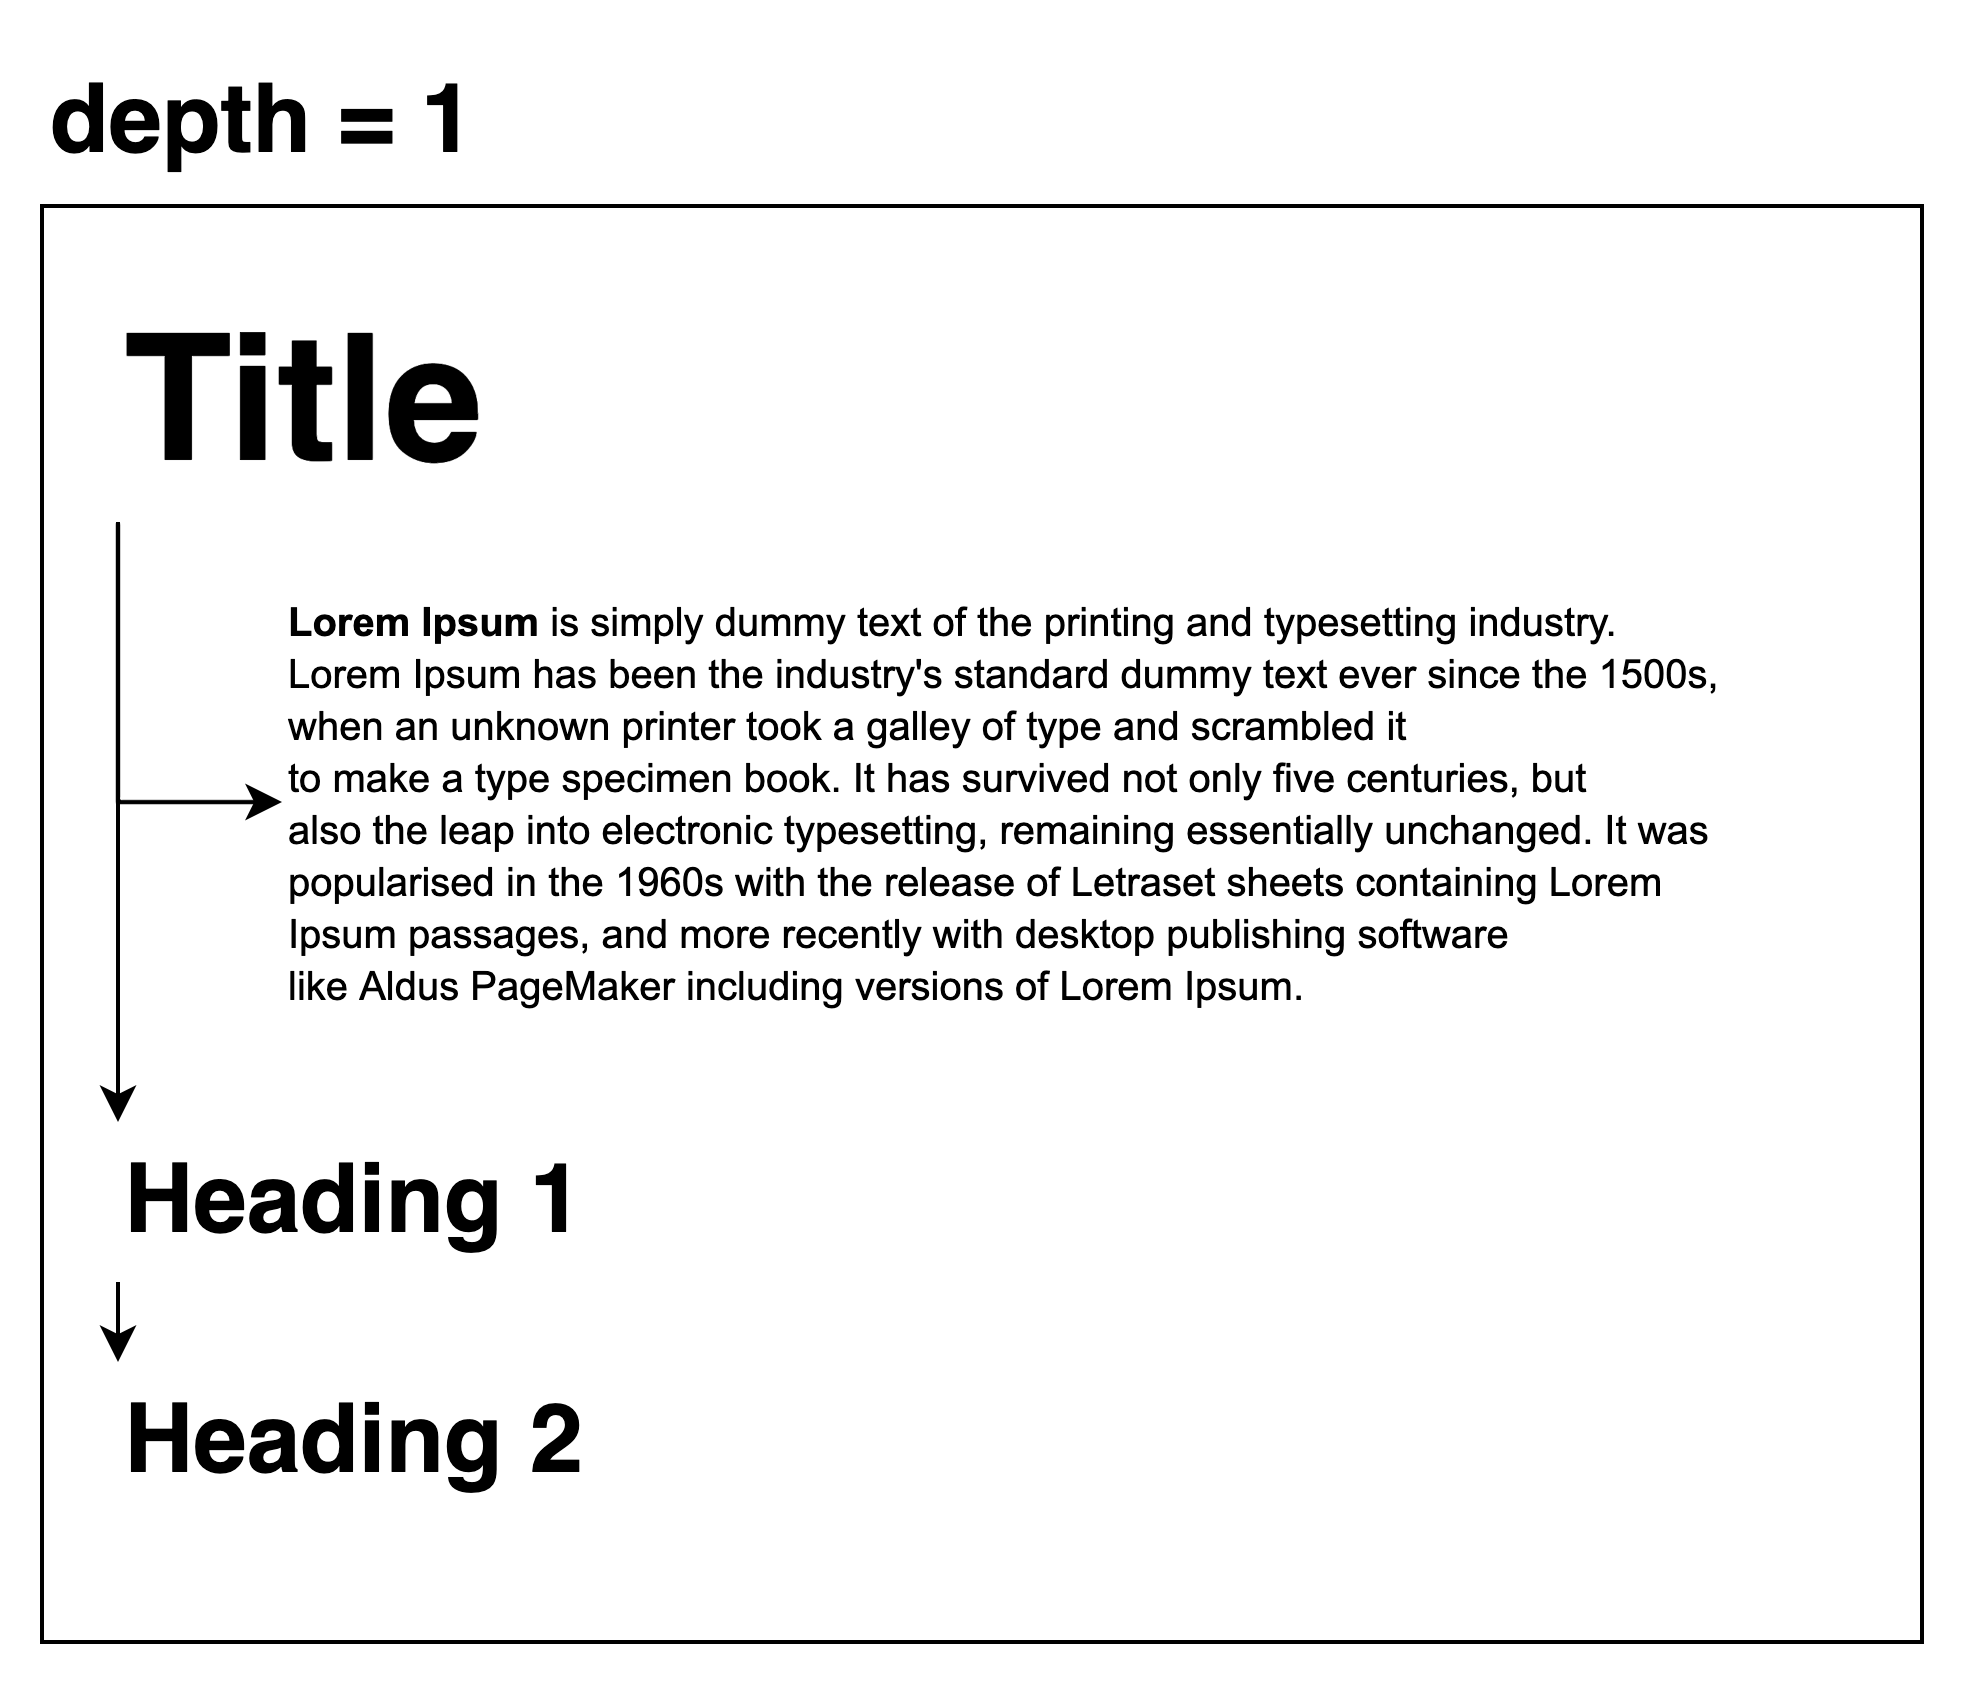

In [18]:
# Step 1 - Create a database of m documents with the aforementioned structure
database = pd.DataFrame()
database['topic'] = []
database['text'] = []
database['headings'] = []
database['documenttotokenise'] = []

for headingid in headings.index:
    titleinput = headings.iloc[headingid]['heading']
    textids = headings.iloc[headingid]['paragraphs']
    textinput = []
    for textid in textids:
        for line in text.iloc[textid]['lines']:
            textinput.append(line)
    headingids = get_subheadings(headingid, headings)
    headingsinput = []
    for headingid in headingids:
        headingsinput.append(headings.iloc[headingid]['heading'])
    database = update_database(database, titleinput, textinput, headingsinput)

/Users/chinmayshrivastava/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
# Step 2 - Define n-gram range
ngramrange = (1, 3)

In [20]:
# Step 3 - Tokenisation - For each document, create a set of n-grams of length 1 and 2, and,
# Step 4 - Perform TF-IDF on the tokens and all the documents
vectorizer = CountVectorizer(analyzer='word', ngram_range=ngramrange)
docs = list(database['documenttotokenise'])
X = vectorizer.fit_transform(docs)
countmatrix = X.toarray()
vocabularyX = vectorizer.vocabulary_

tfidfvectorizer = TfidfVectorizer(analyzer='word', ngram_range=ngramrange)
docs = list(database['documenttotokenise'])
Y = tfidfvectorizer.fit_transform(docs)
tfidfmatrix = Y.toarray()
vocabularyY = tfidfvectorizer.vocabulary_
idf = tfidfvectorizer.idf_

In [71]:
# doc 520 "proof of work"
# doc 1810 "zero knowledge proofs", "cryptography even though", 
# "form of zcash", "fully homomorphic encryption", "nightfall and zokrates"
# doc 619 "view raises some", "preferable to traditional", "to traditional databases"
def make_subelements(listof3words):
    subelements = []
    subelements.append(' '.join([listof3words[0], listof3words[1], listof3words[2]]))
    subelements.append(' '.join([listof3words[0], listof3words[1]]))
    subelements.append(' '.join([listof3words[1], listof3words[2]]))
    subelements.append(listof3words[0])
    subelements.append(listof3words[1])
    subelements.append(listof3words[2])
    return subelements
docid = 1810
candidates = make_subelements('in cryptography new'.split(' '))

In [72]:
for element in candidates:
    print(element)

for element in candidates:
    print(countmatrix[docid, vocabularyX[element]])

for element in candidates:
    print(sum(countmatrix[:, vocabularyX[element]]))

for element in candidates:
    print(tfidfmatrix[docid, vocabularyY[element]])

for element in candidates:
    print(tfidfmatrix[docid, vocabularyY[element]]/countmatrix[docid, vocabularyX[element]])

for element in candidates:
    print(idf[vocabularyY[element]])

in cryptography new
in cryptography
cryptography new
in
cryptography
new
1
1
1
8
7
1
1
6
1
4628
191
346
0.05463584123127863
0.04590612342507006
0.05463584123127863
0.08899333086905423
0.18878560460559238
0.023051003956502326
0.05463584123127863
0.04590612342507006
0.05463584123127863
0.011124166358631778
0.026969372086513198
0.023051003956502326
7.840546529288687
6.587783560793319
7.840546529288687
1.596379628624951
3.870254615736565
3.307947036135431


In [11]:
database.iloc[1810]['documenttotokenise']

"Cryptography Even though cryptography was an area of keen interest and research for many decades before  Bitcoin's invention, blockchain technology has resulted in a renewed interest in this field   With the advent of blockchains and related technologies, there has been a simultaneous and  significant increase in the interest in cryptography  New research is being carried out and  published regularly, especially in the area of financial cryptography  Technologies such as  zero-knowledge proofs  ( ZKPs ), fully  homomorphic encryption , and  functional encryption are being researched for their potential use in blockchains  Already,  ZKPs have been implemented for the first time at a practical level in the form of Zcash,  which has addressed privacy issues in cryptocurrency networks  It's evident that blockchains  and cryptocurrencies have helped with the advancement of cryptography, especially financial  cryptography   Other developments such as Zether,  zk-SNARKs ,  zk-STARKs , bullet

In [12]:
# Step 5 - Update the data by choosing either the two gram or the one gram based on the TF-IDF importances.
# only if all the three words occur together, the first two words occur together, or the first word occurs independently,
# we will make 3, 2, and 1 word advancements respectively, other wise just one step.
significant = 0.25

def make_subelements(listof3words):
    subelements = {}
    subelements[1] = [listof3words[0], listof3words[1], listof3words[2]]
    subelements[2] = [' '.join([listof3words[0], listof3words[1]]), ' '.join([listof3words[1], listof3words[2]])]
    subelements[3] = [' '.join([listof3words[0], listof3words[1], listof3words[2]])]
    return subelements

def make_subelementmatrix(docid, listof3words, countmatrix, tfidfmatrix, vocabularycount, vocabularytfidf, lasttwo=False):
    if not lasttwo:
        subelementmatrix = {}
        subelements = make_subelements(listof3words)
        for i in range(3):
            for element in subelements[i]:
                idf = tfidfmatrix[docid, vocabularytfidf[element]]/countmatrix[docid, vocabularycount[element]]
                subelementmatrix[element] = [idf,
                                             countmatrix[docid, vocabularycount[element]], 
                                             sum(countmatrix[:, vocabularycount[element]]), 
                                             tfidfmatrix[docid, vocabularytfidf[element]]]
    else:
        subelementmatrix = {}
        subelements = subelements = {1:[listof3words[0], listof3words[1]], 2:[listof3words[0]+' '+listof3words[1]]}
        for i in range(2):
            for element in subelements[i]:
                idf = tfidfmatrix[docid, vocabularytfidf[element]]/countmatrix[docid, vocabularycount[element]]
                subelementmatrix[element] = [idf,
                                             countmatrix[docid, vocabularycount[element]], 
                                             sum(countmatrix[:, vocabularycount[element]]), 
                                             tfidfmatrix[docid, vocabularytfidf[element]]]
    return subelementmatrix
    
def make_keyelements(listof3words, subelementmatrix, lasttwo=False):
    # technically we are using idf only to combine words
    if not lasttwo:
        subelements = make_subelements(listof3words)
        if subelementmatrix[subelements[2][0]][0]>subelementmatrix[subelements[1][0]][0]:
            if subelementmatrix[subelements[3][0]][0]>subelementmatrix[subelements[2][0]][0]:
                stepsize = 3
                return subelements[3][0], stepsize
            else:
                if subelementmatrix[subelements[2][1]][0]>subelementmatrix[subelements[2][0]][0]:
                    stepsize = 1
                    return subelements[1][0], stepsize
                else:
                    stepsize = 2
                    return subelements[2][0], stepsize
        else:
            stepsize = 1
            return subelements[1][0], stepsize
    else:
        subelements = {1:[listof3words[0], listof3words[1]], 2:[listof3words[0]+' '+listof3words[1]]}
        if subelementmatrix[subelements[2][0]][0]>subelementmatrix[subelements[1][0]][0]:
            stepsize = 2
            return subelements[2][0], stepsize
        else:
            stepsize = 1
            return subelements[1][0], stepsize

def preprocess_string(ourstring):
    ourstring = ourstring.translate(str.maketrans('', '', string.punctuation))
    ourstring = ourstring.lower().split(' ')
    ourstring = [element.strip() for element in ourstring]
    return ourstring

listofupdatedtopics = []
listofupdatedheadings = []
listofupdatedtext = []
for index in database.index:
    topic = database.iloc[index]['topic']
    temptopic = []
    topictoken = preprocess_string(topic)
    i = 0
    while i<len(topictoken)-2:
        next3 = topictoken[0:3]
        subelementmatrix = make_subelementmatrix(index, next3, countmatrix, tfidfmatrix, vocabularyX, vocabularyY)
        keyelements = make_keyelements(next3, subelementmatrix)
        temptopic.append(keyelements[0])
        i+=keyelements[1]
    if i==len(topictoken)-2:
        subelementmatrix = make_subelementmatrix(topictoken[-2:], countmatrix, tfidfmatrix, vocabularyX, vocabularyY, True)
        keyelements = make_keyelements(topictoken[-3:], subelementmatrix, True)
        temptopic.append(keyelements[0])
        i+=keyelements[1]
    if i==len(topictoken)-1:
        temptopic.append(topictoken[i])
        i+=1
    listofupdatedtopics.append(temptopic)

database['updatedtopics'] = listofupdatedtopics

KeyError: 0

UnicodeEncodeError: 'utf-8' codec can't encode characters in position 138-149: surrogates not allowed

In [332]:
a[-3:]

[3, 4, 5]